In [1]:
import d2l
from matplotlib import pyplot as plt
import numpy as np
import os
from PIL import Image
import torch
from torch import nn
from torchvision import transforms

In [2]:
class EarData(d2l.DataModule):
    def __init__(self, batch_size=64, resize=(128, 128), train_split_size=0.7):
        super().__init__()
        self.save_hyperparameters()

        total_data = 0
        male_class = 0 
        for root, dirs, files in os.walk("EarVN1.0/Images"):
            total_data+=len(files)
        split = int(total_data * train_split_size)
        
        random_transforms = [transforms.ColorJitter(brightness=.5, hue=.2), 
                            transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5))
                            ]
        transform= d2l.transforms.Compose([d2l.transforms.Resize(resize),
                                           transforms.RandomHorizontalFlip(p=0.5),
                                           transforms.RandomVerticalFlip(p=0.5),
                                           transforms.RandomApply(transforms=random_transforms, p=0.5), 
                                           transforms.RandomPerspective(distortion_scale=0.4, p=.25),
                                            d2l.transforms.ToTensor()])
        transform_valid = d2l.transforms.Compose([d2l.transforms.Resize(resize),
                                            d2l.transforms.ToTensor()])

        val_data = []
        data = []
        self.names = []

        image_index = 0
        images_folder = "EarVN1.0/Images"
        for ear_folder_name in sorted(os.listdir(images_folder)):
            parts = ear_folder_name.split(".")
            label, name = parts
            label = 0 if int(label) >= 98 else 1
            self.names.append(name)

            ear_folder = images_folder + "/" + ear_folder_name
            for image_name in os.listdir(ear_folder):
                with Image.open(ear_folder + "/" + image_name) as image:
                    if image_index < split:
                        transformed_image = transform(image)
                        data.append((transformed_image, label))
                        transformed_image = transform_valid(image)
                        data.append((transformed_image, label))
                    else:
                        transformed_image = transform_valid(image)
                        val_data.append((transformed_image, label))
                    image_index+=1

        self.train = data
        self.val = val_data
    
    def text_labels(self, indices):
        return [self.names[i] for i in indices]

    def get_dataloader(self, train=True):
        data = self.train if train else self.val
        return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train)

    def visualize(self, batch, nrows=2, ncols=2):
        X, y = batch
        X = X.permute(0, 2, 3, 1)
        labels = self.text_labels(y)
        d2l.show_images(X, nrows, ncols, titles=labels)

In [3]:
data = EarData()

In [4]:
batch_val = next(iter(data.get_dataloader(train=False)))

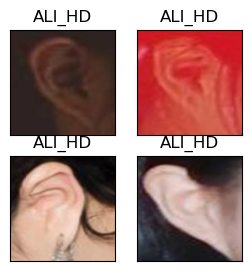

In [5]:
data.visualize(batch_val)

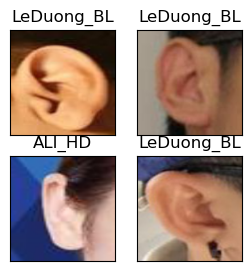

In [6]:
batch = next(iter(data.get_dataloader(train=True)))
data.visualize(batch)

In [7]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [8]:
import d2l
import torch
import torch.nn as nn

class CNNbaseline(d2l.Classifier):
    """The LeNet-5 model."""
    def __init__(self, num_classes=2):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, padding=2), nn.LazyBatchNorm2d(), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.LazyConv2d(16, kernel_size=5), nn.LazyBatchNorm2d(), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.LazyConv2d(32, kernel_size=5, padding=2), nn.LazyBatchNorm2d(), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.LazyConv2d(64, kernel_size=5, padding=2), nn.LazyBatchNorm2d(), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Flatten(),
            nn.LazyLinear(120), nn.LazyBatchNorm1d(), nn.ReLU(), nn.Dropout(0.5), 
            nn.LazyLinear(84), nn.LazyBatchNorm1d(), nn.ReLU(), nn.Dropout(0.5), 
            nn.LazyLinear(num_classes), 
        )
    

In [9]:
def model_training(model, data, optimizer, loss_fn, epochs = 10, early_stopping = True, verbose = True):
    # overall loss value for each epoch:
    loss_train = []
    loss_valid = []
    accuracy_valid = []

    best_val_loss = float('inf')
    patience_counter = 0
    patience = 25

    for epoch in range(epochs) :
        if verbose and (epoch+1)%10 == 0:
            print("epoch", epoch + 1,)
        model.train()
        loss_values = [] # loss values for each batch
        for batch_X, batch_y in data.train_dataloader() :
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            preds = model(batch_X)
            loss = loss_fn(preds, batch_y)
            loss_values.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        loss_train.append(np.mean(loss_values))
        model.eval()
        loss_values = []
        accuracy_values = []
        for batch_X, batch_y in data.val_dataloader() :
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            with torch.no_grad():
                preds = model(batch_X)
                #print(preds)
                loss = loss_fn(preds, batch_y)
                loss_values.append(loss.item())
                accuracy_values.append(model.accuracy(preds, batch_y).item())
        
        if early_stopping:     
            val_loss = np.mean(loss_values)
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                # Save the best model weights here
                torch.save(model.state_dict(), 'best_model.pth')
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping triggered at epoch {epoch}.")
                    break
                
        loss_valid.append(np.mean(loss_values))
        accuracy_valid.append(np.mean(accuracy_values))
        if verbose and epoch%10 == 0:
            print(f"accuracy: {accuracy_valid[-1]:.8f}")
    return model, loss_train, loss_valid, accuracy_valid

In [10]:
def init_cnn(module):  #@save
    """Initialize weights for CNNs."""
    if type(module) == nn.Linear or type(module) == nn.Conv2d:
        nn.init.xavier_uniform_(module.weight)

In [11]:
baseline_model = CNNbaseline(num_classes=2)
baseline_model = baseline_model.to(device)

batch_X = next(iter(data.get_dataloader(train=True)))[0]
batch_X = batch_X.to(device)
baseline_model.apply_init([batch_X], init_cnn)
optimizer = torch.optim.Adam(baseline_model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

/usr/local/anaconda3/2023.03/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [12]:
baseline_model, bass_loss_train, bass_loss_valid, bass_accuracy_valid = model_training(baseline_model, data, 
                                                                                       optimizer, loss_fn,
                                                                                      epochs = 100, early_stopping = False)


accuracy: 0.29586443
epoch 10
accuracy: 0.61975280
epoch 20
accuracy: 0.51997823
epoch 30
accuracy: 0.62511660
epoch 40
accuracy: 0.52608053
epoch 50
accuracy: 0.52044465
epoch 60
accuracy: 0.59005752
epoch 70
accuracy: 0.55317164
epoch 80
accuracy: 0.56980721
epoch 90
accuracy: 0.56141169
epoch 100


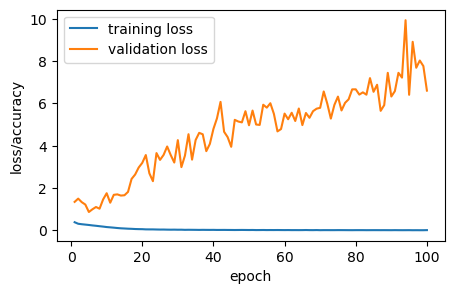

In [13]:
from matplotlib import pyplot as plt
plt.figure(figsize=(5,3))
plt.plot(range(1, len(bass_loss_train)+1), bass_loss_train, label='training loss')
plt.plot(range(1, len(bass_loss_valid)+1), bass_loss_valid, label='validation loss')
plt.xlabel('epoch')
plt.ylabel('loss/accuracy')
plt.legend();

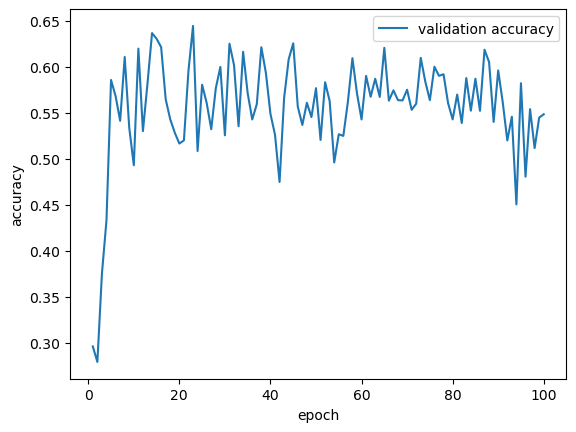

In [14]:
plt.plot(range(1, len(bass_loss_valid)+1), bass_accuracy_valid, label='validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend();

In [15]:
# from matplotlib import pyplot as plt
# plt.figure(figsize=(5,3))
# plt.plot(range(1, len(bass_loss_train)+1), bass_loss_train, label='training loss')
# plt.plot(range(1, len(bass_loss_valid)+1), bass_loss_valid, label='validation loss')
# plt.xlabel('epoch')
# plt.ylabel('loss/accuracy')
# plt.legend();

In [16]:
# plt.plot(range(1, len(bass_loss_valid)+1), bass_accuracy_valid, label='validation accuracy')
# plt.xlabel('epoch')
# plt.ylabel('accuracy')
# plt.legend();

In [21]:
import torchvision
finetune_net = torchvision.models.resnet18(weights='IMAGENET1K_V1')
finetune_net.fc = nn.Linear(finetune_net.fc.in_features, 164)
nn.init.xavier_uniform_(finetune_net.fc.weight);

In [22]:
def accuracy(Y_hat, Y, averaged=True):
    """Compute the number of correct predictions."""
    Y_hat = d2l.reshape(Y_hat, (-1, Y_hat.shape[-1]))
    preds = d2l.astype(d2l.argmax(Y_hat, axis=1), Y.dtype)
    compare = d2l.astype(preds == d2l.reshape(Y, -1), d2l.float32)
    return d2l.reduce_mean(compare) if averaged else compare

In [23]:
model=finetune_net
model=model.to(device)
batch_size=128
param_group=True
learning_rate = 0.001
train_iter = data.get_dataloader(train=True)
test_iter = data.get_dataloader(train=False)

loss_fn = nn.CrossEntropyLoss()

if param_group:
    params_1x = [param for name, param in model.named_parameters() 
                 if name not in ["fc.weight", "fc.bias"]]
    optimizer = torch.optim.SGD([{'params': params_1x},
                                 {'params': model.fc.parameters(),
                                'lr': learning_rate * 10}],
                                lr=learning_rate, weight_decay=0.001)
else:
    optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate,
                                weight_decay=0.001)

In [24]:
epochs = 10
# overall loss value for each epoch:
loss_train = []
loss_valid = []
accuracy_valid = []
for epoch in range(epochs) :
    print("epoch", epoch + 1,)
    model.train()
    loss_values = [] # loss values for each batch
    for batch_X, batch_y in train_iter :
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        preds = model(batch_X)
        loss = loss_fn(preds, batch_y)
        loss_values.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_train.append(np.mean(loss_values))
    model.eval()
    loss_values = []
    accuracy_values = []
    for batch_X, batch_y in test_iter :
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        with torch.no_grad():
            preds = model(batch_X)
            loss = loss_fn(preds, batch_y)
            loss_values.append(loss.item())
            accuracy_values.append(accuracy(preds, batch_y).item())
    loss_valid.append(np.mean(loss_values))
    accuracy_valid.append(np.mean(accuracy_values))
    print ("accuracy: ", accuracy_valid[-1])

epoch 1
accuracy:  0.43295242537313433
epoch 2
accuracy:  0.6769667290039917
epoch 3
accuracy:  0.5020211443527421
epoch 4
accuracy:  0.604088930496529
epoch 5
accuracy:  0.6003575872129469
epoch 6
accuracy:  0.6047496891288615
epoch 7
accuracy:  0.69189210213832
epoch 8
accuracy:  0.695740049899514
epoch 9
accuracy:  0.6761116294273689
epoch 10
accuracy:  0.6628187189796078


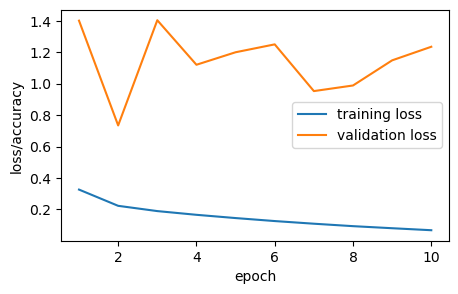

In [25]:
from matplotlib import pyplot as plt
plt.figure(figsize=(5,3))
plt.plot(range(1, len(loss_train)+1), loss_train, label='training loss')
plt.plot(range(1, len(loss_valid)+1), loss_valid, label='validation loss')
plt.xlabel('epoch')
plt.ylabel('loss/accuracy')
plt.legend();

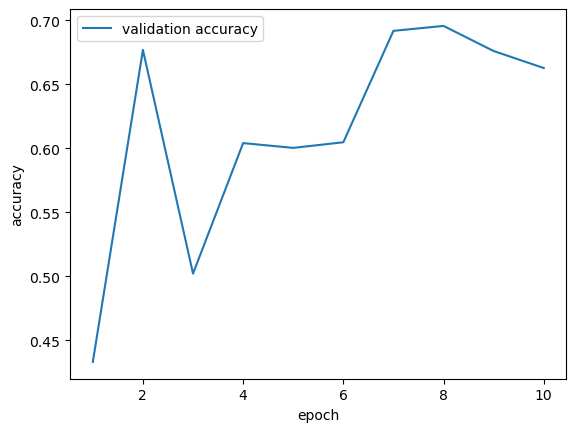

In [26]:
plt.plot(range(1, len(accuracy_valid)+1), accuracy_valid, label='validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend();

In [ ]:
test_iter = data.get_dataloader(train=True)

for batch_X, batch_y in test_iter :
    batch_X, batch_y = batch_X.to(device), batch_y.to(device)
    with torch.no_grad():
        preds = model(batch_X)
        loss = loss_fn(preds, batch_y)
        loss_values.append(loss.item())
        accuracy_values.append(accuracy(preds, batch_y).item())